# Imports

In [1]:
import numpy as np
import itertools
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pixiedust

Pixiedust database opened successfully


# Introduction

Consider the following equation:
$$\Delta_p \Psi(x,y)=f(x,y)$$

$x \in [0,1],\ y \in [0,1]$ with *Dirichlet* BC: $\Psi(0,y) = 0$, $\Psi(1,y) = 0$, $\Psi(x,0) = 0$ and $\Psi(x,1) = 0$.

For this first attempt, we will take $p=2$.

# Defining functions

## Sigmoid

Sigmoid $\sigma(x) = \frac{1}{1+e^{-x}}$ and its derrivatives.

Sigmoid with parameter $t$
$$ \sigma_t(x) = \frac{1}{1+e^{-tx}}$$

In [2]:
T = 1

In [3]:
def sig(x):
    return 1 / (1 + np.exp(-T*x))

def sig1(x):
    return T * sig(x) * (1 - sig(x))

def sig2(x):
    return T * (sig1(x) - 2*sig(x)*sig1(x))

def sig3(x):
    return T * (sig2(x) - 2 * (sig1(x)**2 + sig(x) * sig2(x)))

def sig_pr(x, k):
    if k==0:
        return sig(x)
    if k==1:
        return sig1(x)
    if k==2:
        return sig2(x)
    if k==3:
        return sig3(x)

## RHS

The right side of the equation:  $f(x,y) = 6 x (x-1) (1-2 y) + 2 y (y-1) (1-2 y)$

In [4]:
K=1
def f(x, y):
    return K * 6*(x-1)*x*(1-2*y) + 2*(y-1)*y*(1-2*y)

The analytic solution is given by: $\ \Psi_a(x,y) = x (1-x) y (1-y) (1-2 y)$

In [5]:
# def psi_a(x, y):
#     return y * (1-y) * np.sin(np.pi * x)

def psi_a(x, y):
    return K * x*(1-x)*y*(1-y)*(1-2*y)

$$\frac{\partial}{\partial x} \Psi_a = (1-2x) y (1-y) (1-2 y)$$

In [6]:
def psi_a_dx(x,y):
    return K * (1-2*x)*y*(1-y)*(1-2*y)

$$\frac{\partial}{\partial y} \Psi_a = x (1-x) (1-6y + 6y^2) $$

In [7]:
def psi_a_dy(x,y):
    return K * x*(1-x)*(1-6*y+6*(y**2))

## Neural Network

The output of neural network $N(x,y,\vec{p})$, where $\vec{p} = [w, u, v]$:
$$N = \sum_i^H v_i \sigma(z_i) \text{, where } z_i = w_{i0} x + w_{i1} y + u_i$$

In [8]:
def z(x, y, p):
    z_x = np.multiply(x, p[0][0])
    z_y = np.multiply(y, p[0][1])
    z_ = np.array([z_x, z_y, p[1]]).sum(axis=0)
    return z_

def N(x, y, p):
    return np.sum(np.multiply(sig(z(x,y,p)), p[2]))

$$\frac{\partial^k N}{\partial x_j^k} = \sum_{i=1}^H v_i w_{ij}^k \sigma^{(k)}$$

In [9]:
def dN_dxj_k(x, y, p, j, k):
    wj = p[0][j]
    v = p[2]
    z_ = z(x, y, p)
    
    return np.sum(v * (wj**k) * sig_pr(z_, k))

$$\frac{\partial N}{\partial w_j} = x_j v \sigma '$$

In [10]:
def dN_dwj(x, y, p, j):
    xj = x if j==0 else y
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' + v_i \sigma' \quad\text{ if } j = k$$

$$ \frac{\partial}{\partial w_j} \frac{\partial N}{\partial x_k} = x_j v w_k \sigma'' \quad\text{ if } j \neq k$$

In [11]:
def d_dwj_dN_dxk(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * wk * sig2(z_) + jk * v * sig1(z_)

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} + 2 v w_k \sigma'' \quad\text{ if } j = k $$

$$ \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x_k^2} = x_j v w_k^2 \sigma^{(3)} \quad\text{ if } j \neq k $$

In [12]:
def d_dwj_dN2_dxk2(x, y, p, j, k):
    xj = x if j==0 else y
    wk = p[0][k]
    jk = 1 if j==k else 0
    v = p[2]
    z_ = z(x, y, p)
    return xj * v * (wk**2) * sig3(z_) + jk * 2 * v * wk * sig2(z_)

$$ \frac{\partial}{\partial u} \frac{\partial^k}{\partial x_j^k} N = v w_j^k \sigma^{(k+1)} $$

In [13]:
def d_du_dkN(x, y, p, j, k):
    v = p[2]
    wj = p[0][j]
    z_ = z(x, y, p)
    return v * (wj**k) * sig_pr(z_, k+1)

$$ \frac{\partial}{\partial v} \frac{\partial^k}{\partial x_j^k} N = w_j^k \sigma^{(k)} $$

In [14]:
def d_dv_dkN(x, y, p, j, k):
    wj = p[0][j]
    z_ = z(x, y, p)
    return (wj**k) * sig_pr(z_, k)

## Cost function

$$E[\vec{p}] = \sum_{i \in \hat{D}} \left\{ \frac{\partial^2 N}{\partial x^2} + \frac{\partial^2 N}{\partial y^2} - f(x,y) \right\}^2 
           +  \sum_{i \in \partial \hat{D}} N^2$$

In [15]:
BC=1

In [16]:
def error_term1(x, y, p):
    return dN_dxj_k(x,y,p,0,2)  +  dN_dxj_k(x,y,p,1,2)  -  f(x,y)

In [17]:
def cost(points, boundary_points, p):
    et1 = []
    et2 = []
    for x, y in points:
        err_sq = error_term1(x, y, p)**2
        et1.append(err_sq)
    
    for x, y in boundary_points:
        err_sq = N(x,y,p)**2
        et2.append(err_sq)
        
    cost = sum(et1) + BC*sum(et2)
    
    return cost

In [18]:
# def relative_err(all_points, p, dOmega):
#     trial1 = np.sum(dOmega*np.array([np.linalg.norm(N(x,y,p) - psi_a(x,y))**2
#                                      for x, y in all_points]))

#     trial2 = np.sum([dOmega*((dN_dxj_k(x,y,p,0,1)-psi_a_dx(x,y))**2 +
#                              (dN_dxj_k(x,y,p,1,1)-psi_a_dy(x,y))**2)
#                      for x, y in all_points])

#     ana1 = np.sum(dOmega*np.array([np.linalg.norm(psi_a(x,y))**2
#                                          for x, y in all_points]))
#     ana2 = np.sum([dOmega*(psi_a_dx(x,y)**2 + psi_a_dy(x,y)**2)
#                    for x, y in all_points])
    
#     relative_err = (trial1 + trial2)**(1/2) / (ana1 + ana2)**(1/2)

#     return relative_err

def relative_err(all_points, p, dOmega):
    #this abs error
    nx=30
    all_points = list(itertools.product(np.linspace(0, 1, nx), np.linspace(0, 1, nx)))
    abs_err = np.sum(np.array([np.linalg.norm(N(x,y,p) - psi_a(x,y))
                                     for x, y in all_points])) / len(all_points)
    return abs_err

# Gradients

$$ \frac{\partial E[\vec{p}]}{\partial w_j} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error_term1) } \left( \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial x^2} + \frac{\partial}{\partial w_j} \frac{\partial^2 N}{\partial y^2} \right) \right\}  +  \sum_{i \in \partial \hat{D}} 2 N \frac{\partial N}{\partial w_j}$$

In [19]:
def dE_dwj(points, boundary_points, p, j):
    t1 = []
    t2 = []
    for x, y in points:
        tmp = 2 * error_term1(x,y,p) * (d_dwj_dN2_dxk2(x,y,p,j,0) + d_dwj_dN2_dxk2(x,y,p,j,1))
        t1.append(tmp)
        
    for x, y in boundary_points:
        tmp = 2 * N(x,y,p) * dN_dwj(x,y,p,j)
        t2.append(tmp)
    
    grad = sum(t1) + BC*sum(t2)
    
    return grad

$$ \frac{\partial E[\vec{p}]}{\partial u} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error_term1) } \left( \frac{\partial}{\partial u} \frac{\partial^2 N}{\partial x^2} + \frac{\partial}{\partial u} \frac{\partial^2 N}{\partial y^2} \right) \right\} +  \sum_{i \in \partial \hat{D}} 2 N \frac{\partial N}{\partial u}$$

In [20]:
def dE_du(points, boundary_points, p):
    t1 = []
    t2 = []
    for x, y in points:
        tmp = 2 * error_term1(x,y,p) * (d_du_dkN(x,y,p,0,2) + d_du_dkN(x,y,p,1,2))
        t1.append(tmp)
        
    for x, y in boundary_points:
        tmp = 2 * N(x,y,p) * d_du_dkN(x,y,p,0,0)
        t2.append(tmp)
    
    grad = sum(t1) + BC*sum(t2)
    
    return grad

$$ \frac{\partial E[\vec{p}]}{\partial v} = \sum_{i \in \hat{D}} \left\{ 2 \text{ (error_term1) } \left( \frac{\partial}{\partial v} \frac{\partial^2 N}{\partial x^2} + \frac{\partial}{\partial v} \frac{\partial^2 N}{\partial y^2} \right) \right\}  +  \sum_{i \in \partial \hat{D}} 2 N \frac{\partial N}{\partial v}$$

In [21]:
def dE_dv(points, boundary_points, p):
    t1 = []
    t2 = []
    for x, y in points:
        tmp = 2 * error_term1(x,y,p) * (d_dv_dkN(x,y,p,0,2) + d_dv_dkN(x,y,p,1,2))
        t1.append(tmp)
        
    for x, y in boundary_points:
        tmp = 2 * N(x,y,p) * d_dv_dkN(x,y,p,0,0)
        t2.append(tmp)
    
    grad = sum(t1) + BC*sum(t2)
    
    return grad

# NN class

In [22]:
class NNTrain:
    def __init__(self, nx=10, hidden_nodes=10, lr=0.1, update_interval=50, if_rel_err=False, bx=10):
        self.training_started = False
        self.nx = nx
        self.hidden_nodes = hidden_nodes
        self.lr = lr
        self.update_interval = update_interval
        self.dOmega = (1. / nx)**2
        self.boundary_points = list(set(list(itertools.product([0, 1], np.linspace(0,1,bx))) +
                                        list(itertools.product(np.linspace(0,1,bx), [0, 1]))))
        pnts = list(itertools.product(np.linspace(0, 1, nx), np.linspace(0, 1, nx)))
        self.points = [(x,y) for x,y in pnts if (x not in [0,1] and y not in [0,1])]
        self.cost_rate = []
        self.if_rel_err = if_rel_err
        if self.if_rel_err:
            self.rel_err = []
        self.p = np.array([np.random.randn(2,hidden_nodes),
                           np.random.randn(hidden_nodes),
                           np.random.randn(hidden_nodes)])

    def train(self, itr=1000):
        if self.training_started:
            mode='a'
        else:
            mode='w'
        self.training_started=True
        
        with open('output/output.csv', mode) as file:
            if mode=='w':
                if self.if_rel_err:
                    file.write('Iteration,Cost,Cost Diff,Relative Error,Relative Error Diff\n')
                else:
                    file.write('Iteration,Cost,Cost Diff\n')
            start=len(self.cost_rate)-1
            if start<1:
                start+=1
                self.cost_rate.append(cost(self.points,self.boundary_points,self.p))
                if self.if_rel_err:
                    self.rel_err.append(relative_err(self.points+self.boundary_points,self.p,self.dOmega))

            i = start
            while i < start+itr:
                self.p[0][0] -= self.lr * dE_dwj(self.points, self.boundary_points, self.p, 0)
                self.p[0][1] -= self.lr * dE_dwj(self.points, self.boundary_points, self.p, 1)
                self.p[1] -= self.lr * dE_du(self.points, self.boundary_points, self.p)
                self.p[2] -= self.lr * dE_dv(self.points, self.boundary_points, self.p)
                
                self.cost_rate.append(cost(self.points,self.boundary_points,self.p))
                cost_diff = self.cost_rate[i]-self.cost_rate[i+1]
                if self.if_rel_err:
                    self.rel_err.append(relative_err(self.points+self.boundary_points,self.p,self.dOmega))
                    rel_diff = self.rel_err[i]-self.rel_err[i+1]

                if self.if_rel_err:
                    file.write('{},{:.8f},{:.8f},{:.8f},{:.8f}\n'.format(
                        i+1,self.cost_rate[i+1], cost_diff,
                        self.rel_err[i+1], rel_diff))
                else:
                    file.write('{},{:.8f},{:.8f}\n'.format(
                        i+1,self.cost_rate[i+1],
                        cost_diff))

                if i%self.update_interval==0:
                    file.flush()
                    
                i+=1
                
    def save_result(self, output_name=''):
        timestr = time.strftime("%Y%m%d-%H%M")
        np.savez('output/'+ timestr + '_' + output_name +'_nn_params.npz', self.p)
        np.savez('output/'+ timestr + '_' + output_name +'_cost_rate.npz', self.cost_rate)
        if self.if_rel_err:
            np.savez('output/'+ timestr + '_' + output_name +'_rel_err.npz', self.rel_err)

# Graphs

In [23]:
%matplotlib notebook
%matplotlib notebook

## Hidden Nodes

In [24]:
def plot_nodes(a, save_name=None):
    p = a.p
    hmax = a.p[0][0].shape[0]
    col = int(np.sqrt(hmax)) if int(np.sqrt(hmax)) < 10 else 10
    row = np.ceil(hmax / col)
    
    d_x=0.1

    fig = plt.figure(figsize=(col*3, row*3), dpi=150)
    for h in range(1,hmax+1):
        ax = fig.add_subplot(row,col,h, projection='3d')
        x = y = np.arange(0, 1+d_x, d_x)
        X, Y = np.meshgrid(x, y)

        zs = np.array([sig(z(x,y,p))[h-1] for x,y in zip(np.ravel(X), np.ravel(Y))])
        Z = zs.reshape(X.shape)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlim(0,1)

        ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
        ax.title.set_text('Hidden Node: ' + str(h))
        time.sleep(0.2)

    if save_name is None: 
        plt.savefig('t'+str(T)+'_h'+str(hmax)+'_n'+str(a.nx)+'.png')
    else:
        plt.savefig(save_name)

## Error vs Iterations

In [25]:
def plot_iteration(arr, min_it=0, max_it=None):
    plt.figure()
    plt.plot(np.arange(len(arr[min_it:max_it])), np.array(arr[min_it:max_it]))
    plt.show()

## Solution Accuracy on the domain

In [26]:
def accuracy(p):
    d_x=0.01
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0+d_x, d_x)
    X, Y = np.meshgrid(x, y)

    zs = np.array([psi_a(x,y)-psi_t(x,y,p) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
    # ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
#     ax.set_zlabel('Accuracy')


    plt.show()

In [27]:
def plot_fun(fun, zlim=False, title=None, return_ax=False, **kwargs):
    d_x=0.01
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1.0+d_x, d_x)
    X, Y = np.meshgrid(x, y)

    zs = np.array([fun(x,y,**kwargs) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm_r)
    # ax.ticklabel_format(style='sci', axis='z', scilimits=(0,0), useOffset=True, useMathText=True)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.title.set_text(title)
    
    if zlim:
        ax.set_zlim(0,1)

    if return_ax:
        return ax
    else:
        plt.show()

# Training

In [190]:
K=10

BC=10000

a.lr=0.0000001

a.train(itr=20000)

KeyboardInterrupt: 

In [28]:
a = NNTrain(nx=20, bx=60, hidden_nodes=20, lr=0.0001, update_interval=5, if_rel_err=True)

In [29]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [30]:
a.p = np.load('p_backup.npz')['arr_0']

In [39]:
K=10

In [230]:
np.savez('p_backup',a.p)

In [168]:
a.update_interval = 5

In [123]:
a.boundary_points.extend(list(itertools.product(np.logspace(-2,0,10), [0,1])) + 
                         list(itertools.product(1-np.logspace(-2,0,10), [0,1])) + 
                         list(itertools.product([0,1], np.logspace(-2,0,10))) + 
                         list(itertools.product([0,1], 1-np.logspace(-2,0,10))))

In [124]:
len(a.boundary_points)

316

<IPython.core.display.Javascript object>


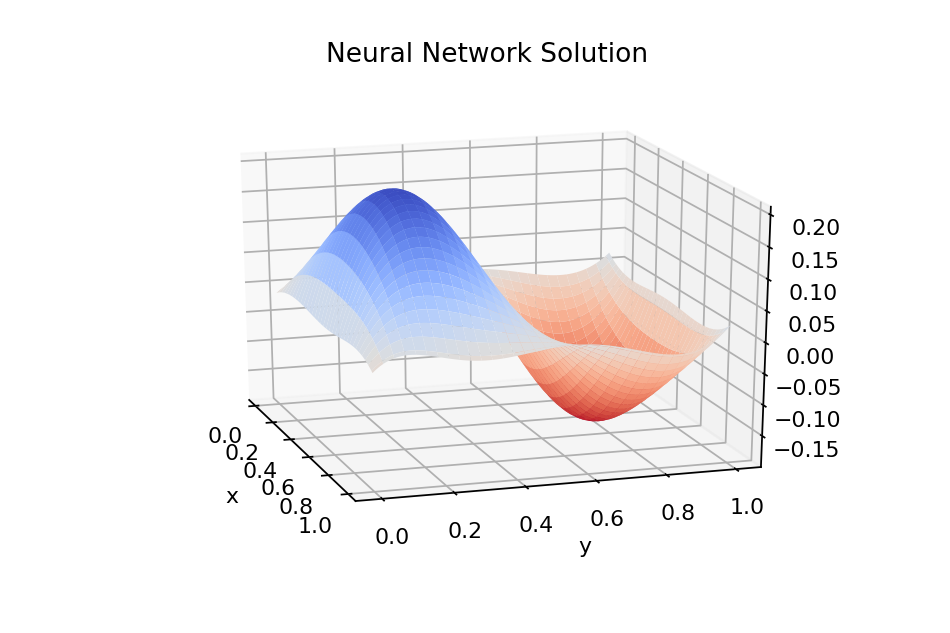

In [35]:
ax = plot_fun(lambda x,y,p: N(x,y,p), p=a.p, title='Neural Network Solution')

<IPython.core.display.Javascript object>


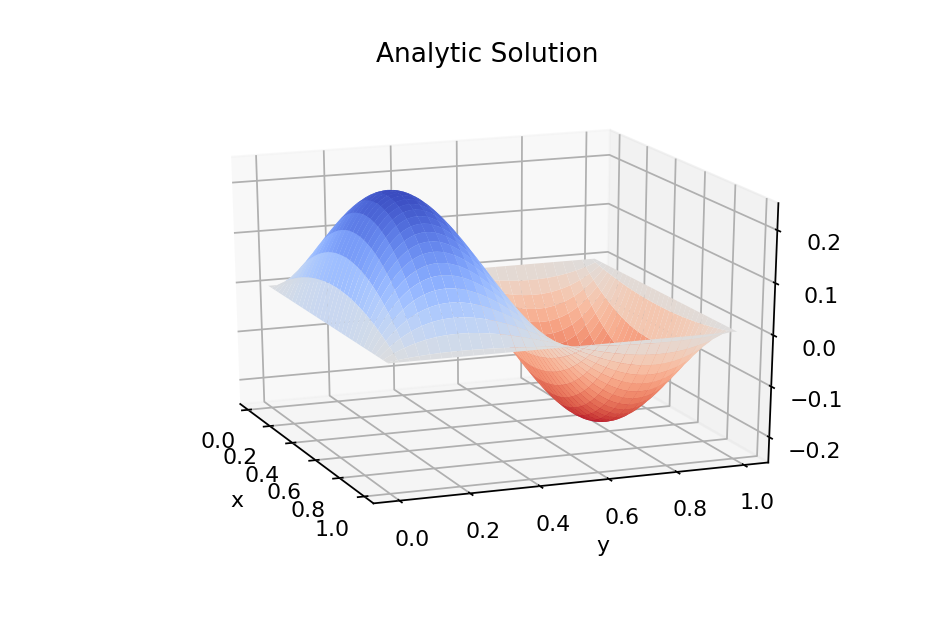

In [40]:
plot_fun(lambda x,y: psi_a(x,y), title='Analytic Solution')

<IPython.core.display.Javascript object>


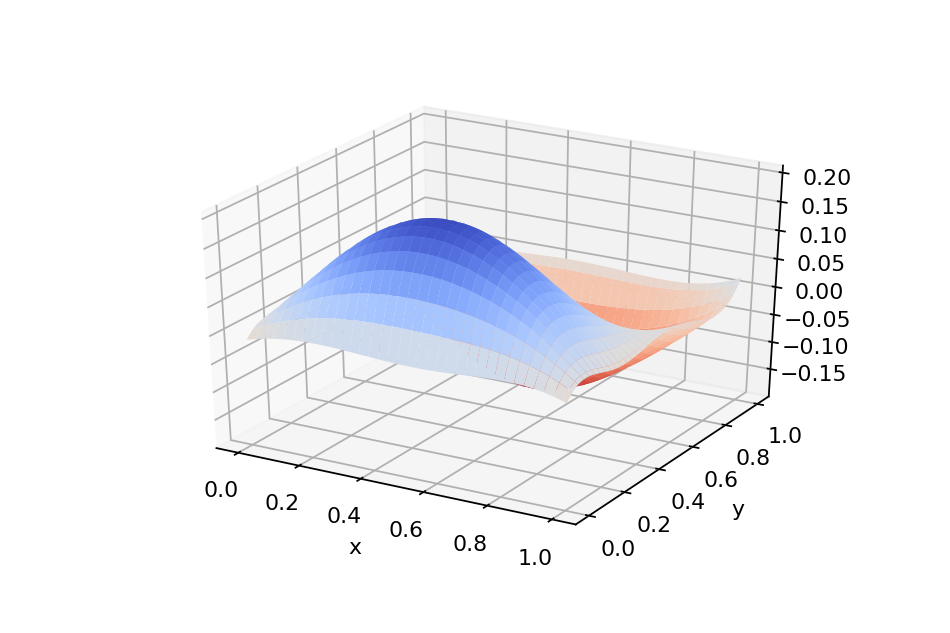

In [37]:
plot_fun(lambda x,y,p: N(x,y,p), p=a.p)

<IPython.core.display.Javascript object>


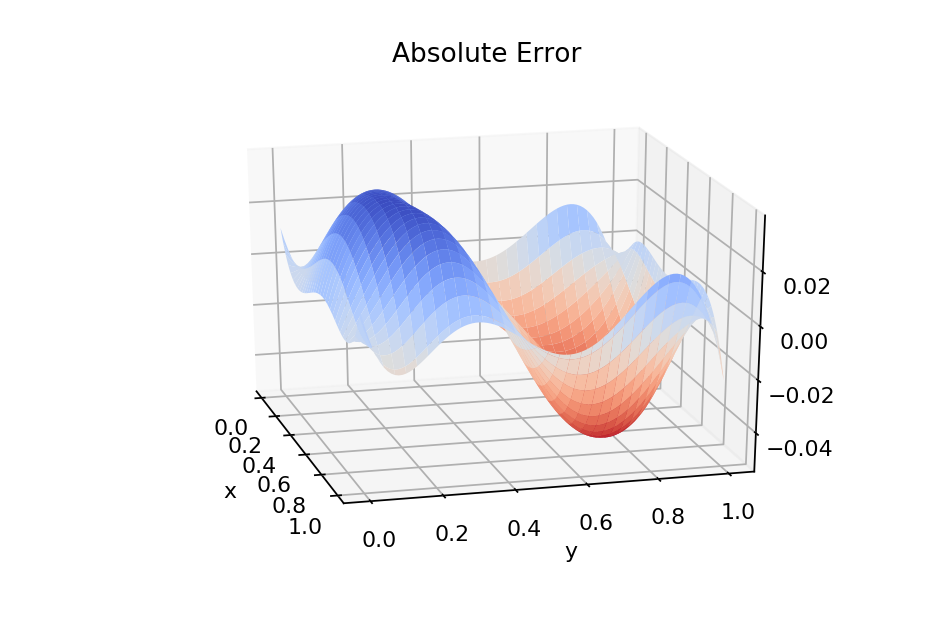

In [42]:
plot_fun(lambda x,y,p: psi_a(x,y)-N(x,y,p), p=a.p, title='Absolute Error')

<IPython.core.display.Javascript object>


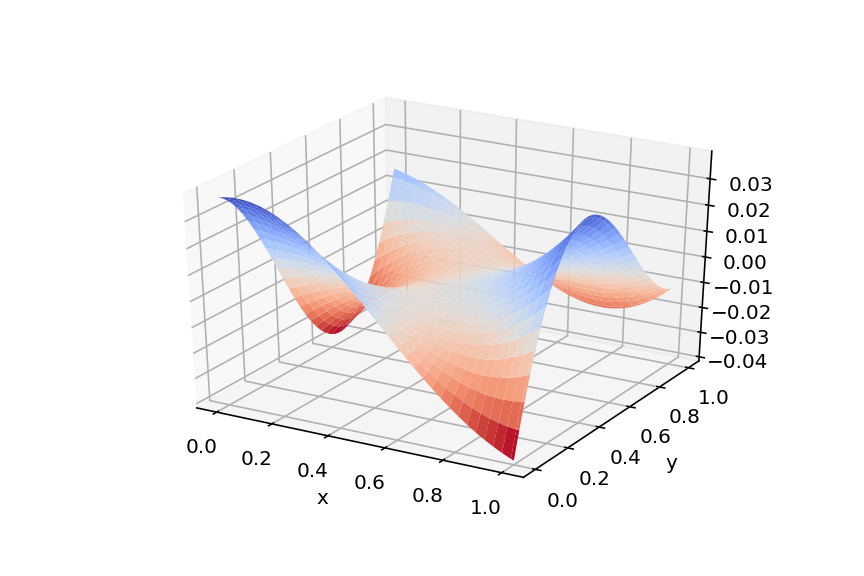

In [31]:
plot_fun(lambda x,y,p: N(x,y,p)-psi_a(x,y), p=a.p)

<IPython.core.display.Javascript object>


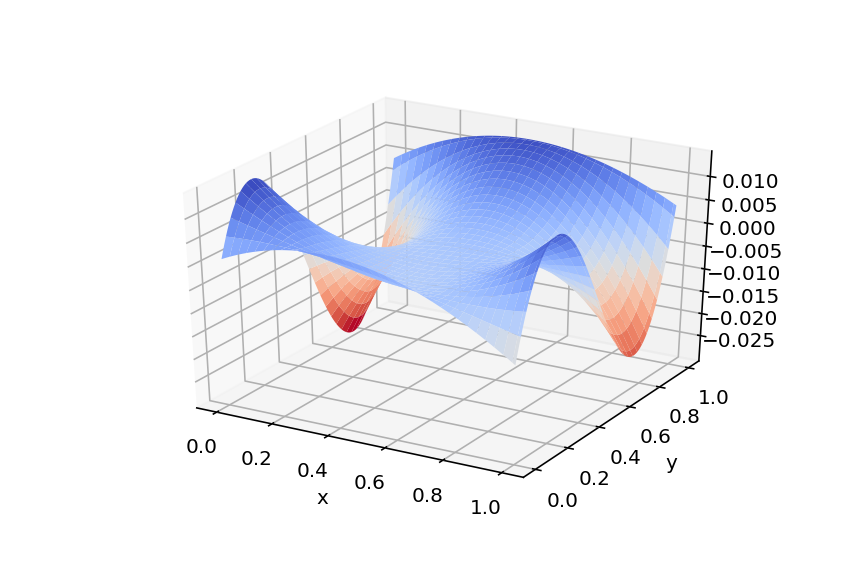

In [31]:
plot_fun(lambda x,y,p: N(x,y,p)-psi_a(x,y), p=a.p)

<IPython.core.display.Javascript object>


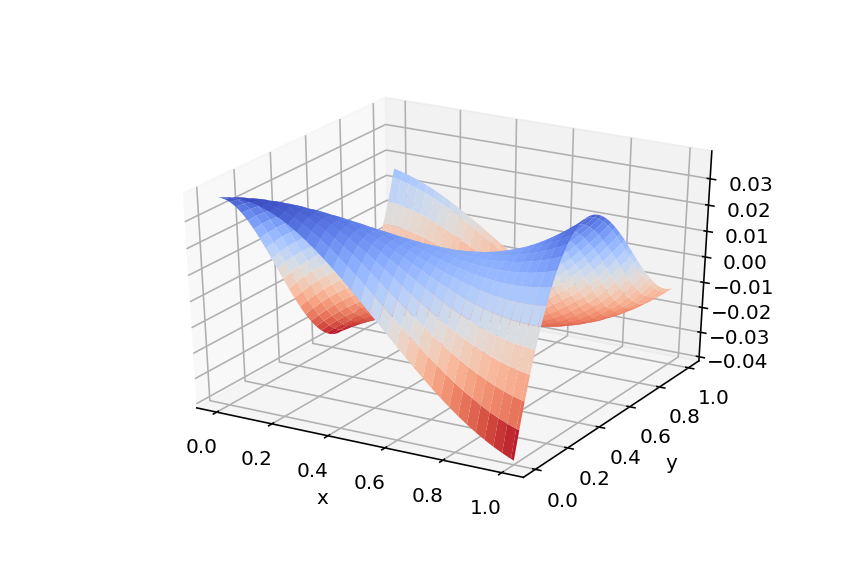

In [32]:
plot_fun(lambda x,y,p: N(x,y,p), p=a.p)

<IPython.core.display.Javascript object>


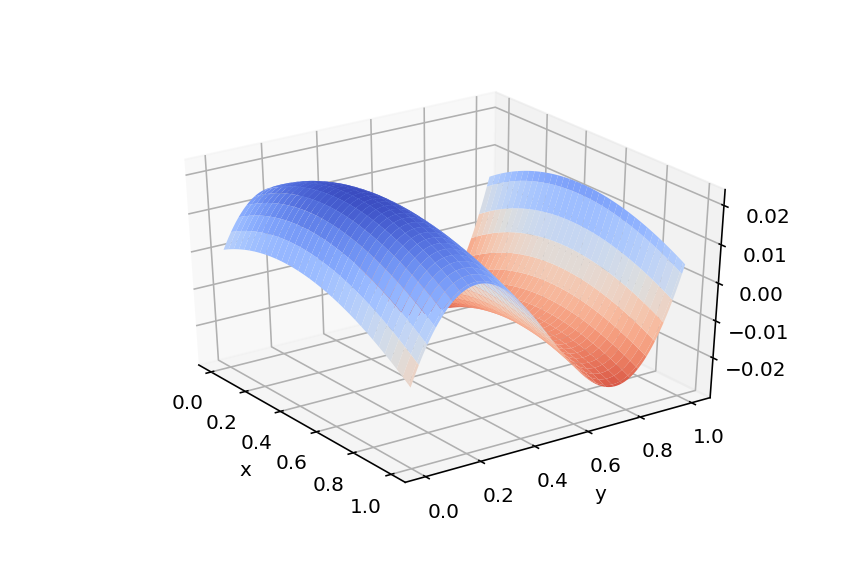

In [32]:
plot_fun(lambda x,y,p: N(x,y,p), p=a.p)

<IPython.core.display.Javascript object>


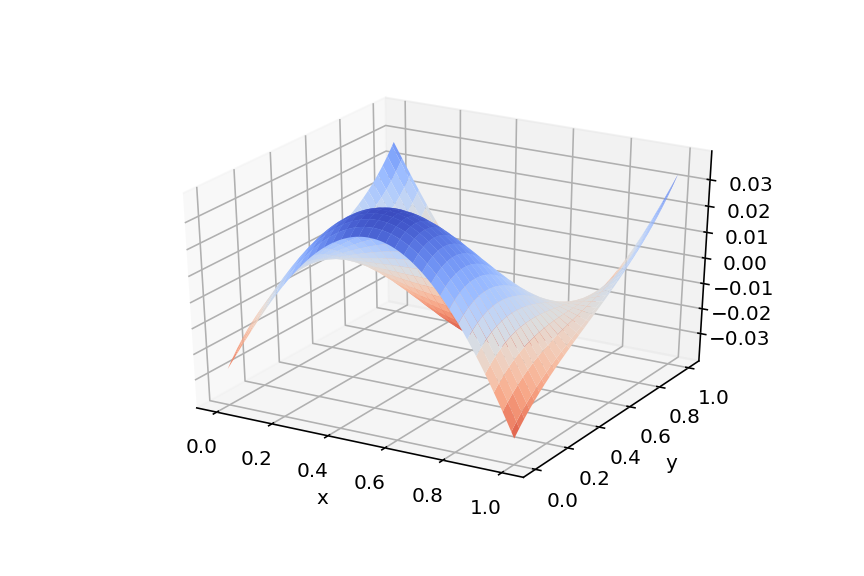

In [40]:
plot_fun(lambda x,y,p: N(x,y,p), p=a.p)

<IPython.core.display.Javascript object>


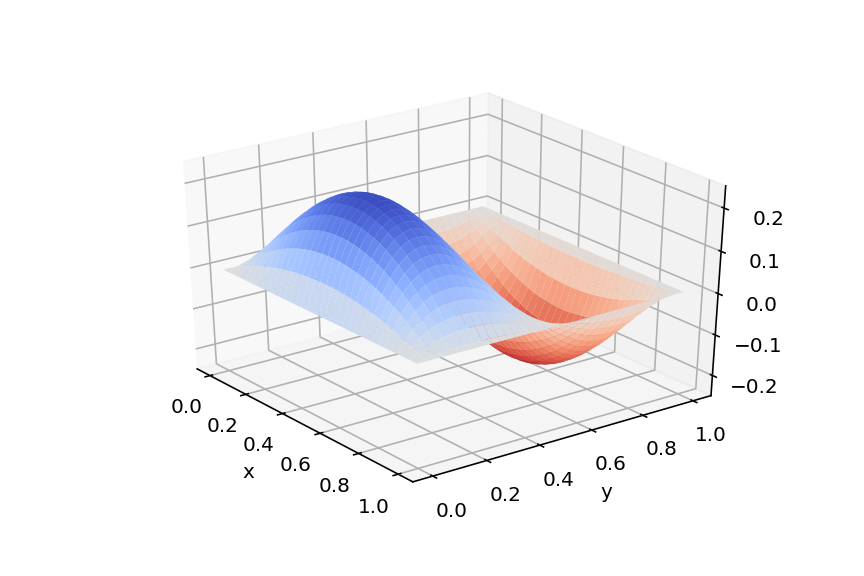

In [132]:
plot_fun(lambda x,y: psi_a(x,y))

<IPython.core.display.Javascript object>


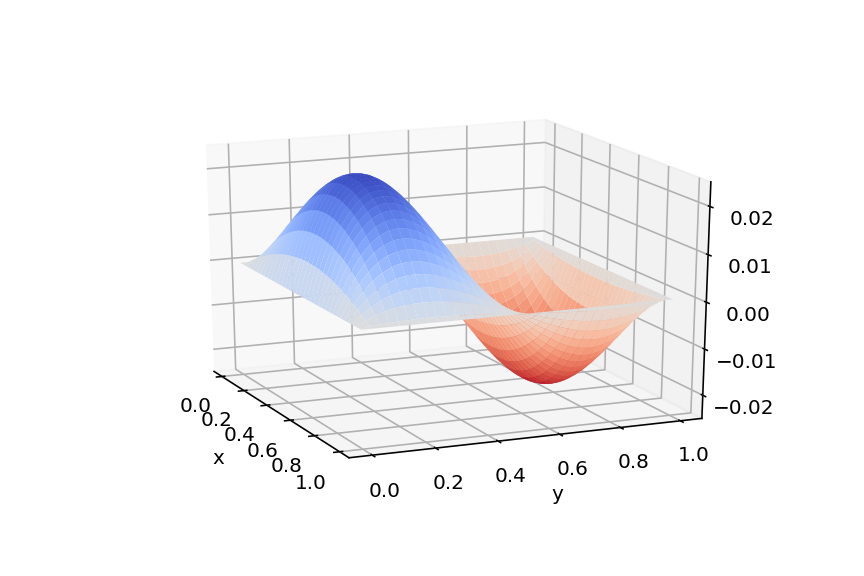

In [45]:
plot_fun(lambda x,y: psi_a(x,y))

In [ ]:
for i in range(10,21):
    T=i
    a = NNTrain(nx=20, hidden_nodes=10, lr=0.00001, update_interval=100, if_rel_err=False)

    a.train(itr=10000)

    a.save_result('new_bc_t'+str(T)+'_h'+str(a.p[0][0].shape[0])+'_n'+str(a.nx)+'_e'+str(int(a.cost_rate[-1]))+'.png')
    plot_nodes(a, 'new_bc_t'+str(T)+'_h'+str(a.p[0][0].shape[0])+'_n'+str(a.nx)+'_e'+str(int(a.cost_rate[-1]))+'.png')

In [28]:
nx=100
test_points = list(itertools.product(np.linspace(0, 1, nx), np.linspace(0, 1, nx)))
print(relative_err(test_points, a.p, None))

NameError: name 'a' is not defined